# Reading ATMOS 60m tower data 

This script is intended to read in ATMOS 60m tower data and create a better file format and working enviroment for the Argonne Testbed for Multiscale Observational Science 60m tower data. The data is read from the currently operation tower website and then reformatted into an xarray data structure and updates file metadata. 

This data is not quality controlled at this point and this is not intended to do quality control. Just a data reformatter and way to easily tinker with tower data

## Imports

In [31]:
import pandas as pd
import xarray as xr
from datetime import datetime, date, timezone
import pytz
import requests
import io

## Variable metadata and renaming
The tower webpage and variable naming is quite old and naming standards can be confusing. This section will go through and create metadata that discusses the the standard long name of the variable and then renames it to a more commonly used or understandable name. 

In [32]:
attrs_dict_tower = {'JDA': {'standard_name': 'Ordinal day of the year'},
                    'T_LST': {'standard_name': 'Central Standard time at end of period'},
                    'TaC_60m': {'standard_name': 'Average 60 m temperature',
                                'units': 'degC'},
                    'spd_60m': {'standard_name': 'Average 60 m wind speed',
                                'units': 'm/s'},
                    'spdv60m': {'standard_name': 'Vector-averaged 60 m wind speed',
                                'units': 'm/s'},
                    'dirV60m': {'standard_name': 'Vector-averaged 60 m wind direction',
                                'units': 'Degees 0-360'},
                    'sdir60m': {'standard_name': 'Standard deviation of 60 m wind direction',
                                'units': 'Degrees 0-360'},
                    'e_10m': {'standard_name': 'Average 10 m vapor pressure',
                              'units': 'kPa'},
                    'rh_10m': {'standard_name': 'Average 10 m relative humidity',
                               'units': 'Percent (%)'},
                    'Tdp_10m': {'standard_name': 'Average 10 m dew point temperature',
                                'units': 'degC'},
                    'TaC_10m': {'standard_name': 'Average 10 m temperature',
                                'units': 'degC'},
                    'spd_10m': {'standard_name': 'Average 10 m wind speed',
                                'units': 'm/s'},
                    'spdV10m': {'standard_name': 'Vector-averaged 10 m wind speed',
                                'units': 'm/s'},
                    'dirV10m': {'standard_name': 'Average 10 m Vector-average 10m wind direction',
                                'units': 'Degrees 0-360'},
                    'sdir10m': {'standard_name': 'Standard deviation of 10 m wind direction',
                                'units': 'Degress 0-360'},
                    'baroKPa': {'standard_name': 'Average station barometric pressure',
                                'units': 'kPa'},
                    'radW/m2': {'standard_name': 'Average global irradiation',
                                'units': 'W/m^2'},
                    'netW/m2': {'standard_name': 'Average net radiation',
                                'units': 'W/m^2'},
                    'Ta_diff': {'standard_name': 'Average temperature different per meter',
                                'units': 'degC/m'},
                    'asp_60m': {'standard_name': '60 m aspirator flow monitor',
                                'units': 'Percent (%) of time flow above minimum'},
                    'asp_10m': {'standard_name': '10 m aspirator flow monitor',
                                'units': 'Percent (%) of time flow above minimum'},
                    'battVDC': {'standard_name': 'Battery voltage monitor',
                                'units': 'V'},
                    'precpmm': {'standard_name': 'Average precipitation',
                                'units': 'mm'}}

variable_mapping_tower = {'TaC_60m': '60m_temperature',
                          'spd_60m': '60m_windspeed',
                          'spdv60m': 'Vector_avg_60m_windspd',
                          'dirV60m': 'Vector_avg_60m_winddir',
                          'sdir60m': 'StdDev_60m_winddir',
                          'e_10m': '10m_vapor_pres',
                          'rh_10m': '10m_relhumidity',
                          'Tdp_10m': '10m_dewpoint',
                          'TaC_10m': '10m_temperature',
                          'spd_10m': '10m_windspeed',
                          'spdV10m': 'vector_avg_10m_windspd',
                          'dirV10m': 'vector_avg_10m_winddir',
                          'sdir10m': 'stdDev_10m_winddir',
                          'baroKPa': 'absolute_pressure',
                          'radW/m2': 'global_irradiation',
                          'netW/m2': 'net_radiation',
                          'Ta_diff': 'temperature_diff',
                          'asp_60m': '60m_asp',
                          'asp_10m': '10m_asp',
                          'precpmm': 'precip'}

## Reading the tower data
This section will read in the last 48 hours of tower data and uses the old tower names to create data columns within pandas. 

In [33]:
cols = ['JDA', 'T_LST', 'TaC_60m', 'spd_60m', 'spdv60m', 'dirV60m', 'sdir60m',
        'e_10m', 'rh_10m', 'Tdp_10m', 'TaC_10m', 'spd_10m', 'spdV10m',
        'dirV10m', 'sdir10m', 'baroKPa', 'radW/m2', 'netW/m2', 'Ta_diff',
        'asp_60m', 'asp_10m', 'battVDC', 'precpmm', 'T_LST2', 'JDA2']


Now we're going to be reading the data off the webpage using pandas ability to extract data from a URL. The read in line will also skip the original header information from the webpage and remove the last line from the data set as it is the header information repeating. 

This read in method reads all data in as an object. To be able to do the work we want to do, we'll have to change the data type of most variables as float but keeping JDA and T_LST as objects. 

In [34]:
# Link to latest 48 hr tower data.
url = 'https://www.atmos.anl.gov/ANLMET/anltower.48'
r=requests.get(url).content


df = pd.read_csv(io.StringIO(r.decode('utf-8')), sep='\s+',  skiprows=[0, 1],
                   header=None, names=cols, na_values=-99999.00)

# Changing the data types from Object to float for most of the columns.
df[['TaC_60m', 'spd_60m', 'spdv60m', 'dirV60m', 'sdir60m', 'e_10m', 'rh_10m',
    'Tdp_10m', 'TaC_10m', 'spd_10m', 'spdV10m', 'dirV10m', 'sdir10m',
    'baroKPa', 'radW/m2', 'netW/m2', 'Ta_diff', 'asp_60m', 'asp_10m',
    'battVDC', 'precpmm']] = df[['TaC_60m', 'spd_60m', 'spdv60m', 'dirV60m',
                                'sdir60m', 'e_10m', 'rh_10m', 'Tdp_10m',
                                 'TaC_10m', 'spd_10m', 'spdV10m', 'dirV10m',
                                 'sdir10m', 'baroKPa', 'radW/m2', 'netW/m2',
                                 'Ta_diff', 'asp_60m', 'asp_10m', 'battVDC',
                                 'precpmm']].apply(pd.to_numeric,
                                                   errors='coerce')

df = df.reset_index(drop=True)
df = df.head(-1)

## Changing the JDA and T_LST to datetime64

The current time structure is formatted to give us the Julian date. This will be converted to a calendar day to make it usable with other data types. However, we have to hard code the year into the data since the website for the tower does not supply a year value. 

Time will also be converted from Central Standard time to UTC, but the JDA and T_LST values will remain in the data file. We will be creating a new variable to store the UTC and date information into and allow the data to be indexed off of those values.


In [ ]:
# Initialize year for redefining time in UTC.
year = "2023"

# Creates an new column of the date and time in UTC.
df['time'] = ""
for i in range(len(df.JDA)):
    doy = df.JDA[i]
    merged_date = datetime.strptime(
        year + "-" + df.JDA[i], "%Y-%j").strftime("%Y-%m-%d")
    local = pytz.timezone("US/Central")
    naive = datetime.strptime(
        merged_date + ' ' + df.T_LST[i], "%Y-%m-%d %H:%M")
    utc_dt = naive.astimezone(timezone.utc)
    df.loc[i,'time'] = datetime.strptime(str(utc_dt)[:19], "%Y-%m-%d %H:%M:%S")

Now the last step is now is changing the data type to datetime64

In [25]:
df['time'] = df['time'].astype('datetime64[ns]')

Now let's change the indexing to be indexed off this new "time" variable 

In [26]:
df.set_index('time', inplace=True)

In the originaly website format, there are repeating columns of date and time. We're going to remove those. 

In [27]:
tower_data = df.iloc[:, :-2]

## Converting to xarray and adding metadata

This next code block will convert it to xarray from pandas, allowing us to use ACT or other python toolkits on it. We'll also loop through and add metadata and rename the variables. 

In [28]:
ds = tower_data.to_xarray()

# Lopping through to rename variables
for variable in attrs_dict_tower.keys():

    if variable in list(ds_tower.variables):

        ds_tower[variable].attrs = attrs_dict_tower[variable]

# Rename the variables
ds = ds.rename(variable_mapping_tower)

We can now check and look at the data in this new format and do an example plot. 

In [29]:
ds

<xarray.Dataset>
Dimensions:                 (time: 192)
Coordinates:
  * time                    (time) datetime64[ns] 2023-06-26T15:00:00 ... 202...
Data variables: (12/23)
    JDA                     (time) object '177' '177' '177' ... '179' '179'
    T_LST                   (time) object '10:00' '10:15' ... '09:30' '09:45'
    60m_temperature         (time) float64 20.55 20.35 19.94 ... 19.44 20.21
    60m_windspeed           (time) float64 7.89 7.34 7.94 ... 2.52 2.88 3.14
    Vector_avg_60m_windspd  (time) float64 7.8 7.25 7.79 7.74 ... 2.21 2.79 3.09
    Vector_avg_60m_winddir  (time) float64 299.2 296.3 298.0 ... 127.8 120.4
    ...                      ...
    net_radiation           (time) float64 141.4 63.36 62.4 ... 357.8 456.5
    temperature_diff        (time) float64 -0.01 -0.009 -0.008 ... -0.012 -0.014
    60m_asp                 (time) float64 100.0 100.0 100.0 ... 100.0 100.0
    10m_asp                 (time) float64 100.0 100.0 100.0 ... 100.0 100.0
    battVDC                 (time) float64 12.82 12.82 12.83 ... 12.86 12.85
    precip                  (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

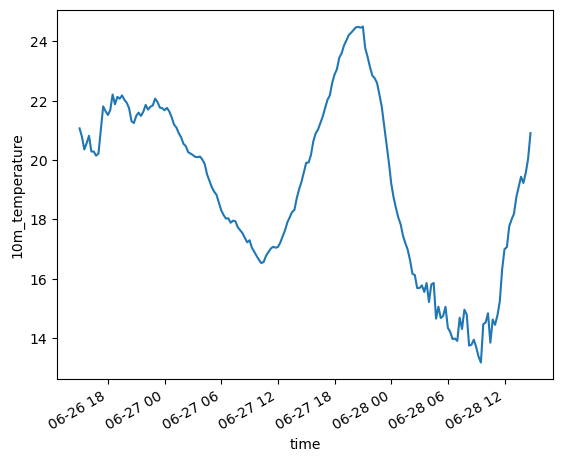

In [30]:
ds['10m_temperature'].plot()